In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class BasicLightning(L.LightningModule):

    def __init__(self):

        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)


    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input* self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = (scaled_top_relu_output +
                               scaled_bottom_relu_output +
                               self.final_bias)

        output = F.relu(input_to_final_relu)

        return output

In [5]:
input_doses = torch.linspace(start=0, end=1, steps=11)

In [6]:
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [7]:
model = BasicLightning()

In [8]:
output_values = model(input_doses)

In [9]:
output_values

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

Text(0.5, 0, 'Dose')

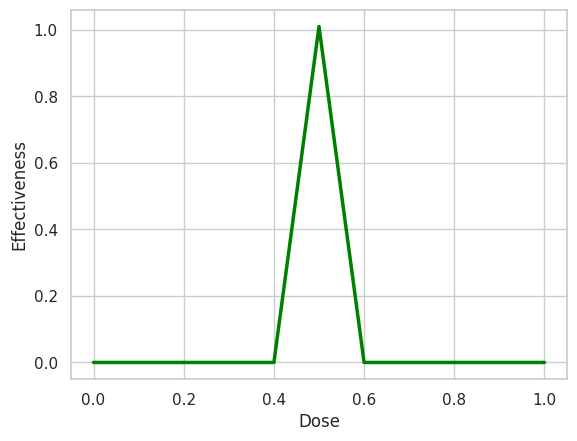

In [10]:
sns.set(style="whitegrid")

sns.lineplot(x=input_doses,
            y=output_values,
            color="green",
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")

In [11]:
class BasicLightningTrain(L.LightningModule):

    def __init__(self):

        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.learning_rate = 0.01

    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input* self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = (scaled_top_relu_output
                               + scaled_bottom_relu_output
                               + self.final_bias)

        output = F.relu(input_to_final_relu)

        return output

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):

        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2

        return loss

Text(0.5, 0, 'Dose')

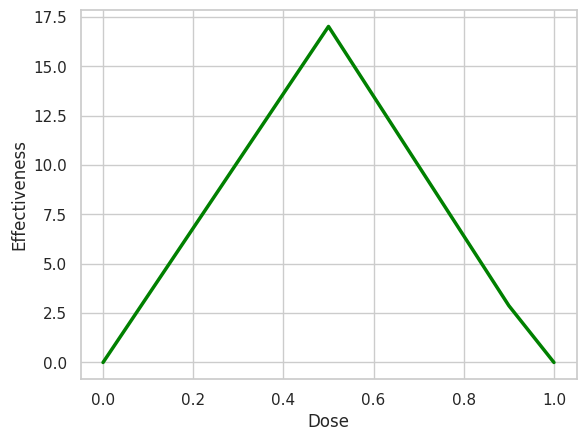

In [12]:
model = BasicLightningTrain()

output_values = model(input_doses)

sns.set(style="whitegrid")

sns.lineplot(x=input_doses,
            y=output_values.detach(),
            color="green",
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")

In [13]:
inputs = torch.tensor([0., 0.5, 1.]*100)
labels = torch.tensor([0., 1., 0.]*100)

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [14]:
model = BasicLightningTrain()
trainer = L.Trainer(max_epochs=34, accelerator="auto", devices="auto")
tuner = L.pytorch.tuner.Tuner(trainer)

lr_find_results = tuner.lr_find(model,
                                train_dataloaders=dataloader,
                                min_lr=0.001,
                                max_lr=1.,
                                early_stop_threshold=None)

new_lr = lr_find_results.suggestion()

print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")

model.learning_rate = new_lr

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.002137962089502232
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.002137962089502232
INFO: Restoring states from the checkpoint path at /content/.lr_find_377c4182-4375-4232-99eb-e9f3c33ed01a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_377c4182-4375-4232-99eb-e9f3c33ed01a.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_377c4182-4375-4232-99eb-e9f3c33ed01a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_377c4182-4375-4232-99eb-e9f3c33ed01a.ckpt


lr_find() suggests 0.00214 for the learning rate.


In [ ]:
trainer.fit(model, train_dataloaders=dataloader)

print(model.final_bias.data)

INFO: 
  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Text(0.5, 0, 'Dose')

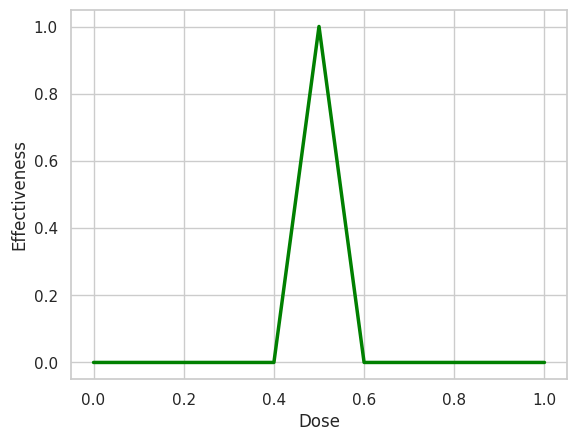

In [17]:
output_values = model(input_doses)

sns.set(style="whitegrid")

sns.lineplot(x=input_doses,
            y=output_values.detach(),
            color="green",
            linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")